In [1]:
import xarray as xr
import numpy as np
from urocc import cpa
import pandas as pd
import matplotlib.pyplot as plt
import dask
from dask import delayed
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from CPA_parallel.CPA_parallel import cpa_multi

In [2]:
fili = '/media/athul/DATA/data_work_pc_kit/IMERG_v7_remapped/tropics_imerg_v07_06UTC_daily_accum_1.0deg_2000_2023.nc'
f = xr.open_dataset(fili)
# f

In [3]:
def return_dates(seas):
    if seas=='JAS':
        strt_tar = '07/01/'
        last_tar = '09/30/'
        
        strt_pre = '06/30/'
        last_pre = '09/29/'
        
    elif seas=='MJ':
        strt_tar = '05/01/'
        last_tar = '06/30/'
        
        strt_pre = '04/30/'
        last_pre = '06/29/'
        
        
    elif seas=='MA':
        strt_tar = '02/28/'
        last_tar = '04/30/'
        
        strt_pre = '02/27/'
        last_pre = '04/29/'
        
        
    elif seas=='ON':
        strt_tar = '10/01/'
        last_tar = '11/30/'
        
        strt_pre = '09/30/'
        last_pre = '11/29/'
        
        
    else:
        print('Invalid season')
        
        
    return strt_tar, last_tar, strt_pre, last_pre

In [4]:
season = 'JAS'

years = np.arange(2010,2016,1)

year_tar = 2016#np.arange(2007,2023,1)

strt_tar, last_tar, strt_pre, last_pre = return_dates(season)

In [5]:
rain_tar = f.precipitation.sel(lat=slice(12, 13), lon=slice(1, 3))
rain_pre = f.precipitation.sel(lat=slice(8, 15), lon=slice(-10, 10))

In [6]:
ts_tar  = pd.to_datetime([])
ts_pre = pd.to_datetime([])
print('year: '+str(year_tar))
for year in years[years!=year_tar]:
    #     target
    t_tar = pd.date_range(start=strt_tar+str(year)+'T06', end=last_tar+str(year)+'T06')
    ts_tar = ts_tar.union(t_tar)
    
    #     predictor
    t_pre = pd.date_range(start=strt_pre+str(year)+'T06', end=last_pre+str(year)+'T06')
    ts_pre = ts_pre.union(t_pre)

year: 2016


In [7]:
rain_tar = rain_tar.sel(time=ts_tar)
rain_pre = rain_pre.sel(time=ts_pre)

In [8]:
rain_tar

<xarray.DataArray 'precipitation' (time: 552, lon: 3, lat: 2)>
[3312 values with dtype=float32]
Coordinates:
  * lon      (lon) float64 1.0 2.0 3.0
  * lat      (lat) float64 12.0 13.0
  * time     (time) datetime64[ns] 2010-07-01T06:00:00 ... 2015-09-30T06:00:00
Attributes:
    units:             mm/hr
    cell_methods:      time: mean
    DimensionNames:    time,lon,lat
    Units:             mm/hr
    CodeMissingValue:  -9999.9
    LongName:          \nComplete merged microwave-infrared (gauge-adjusted)\...
    origname:          precipitation
    fullnamepath:      /Grid/precipitation

In [9]:
rain_pre

<xarray.DataArray 'precipitation' (time: 552, lon: 21, lat: 8)>
[92736 values with dtype=float32]
Coordinates:
  * lon      (lon) float64 -10.0 -9.0 -8.0 -7.0 -6.0 ... 6.0 7.0 8.0 9.0 10.0
  * lat      (lat) float64 8.0 9.0 10.0 11.0 12.0 13.0 14.0 15.0
  * time     (time) datetime64[ns] 2010-06-30T06:00:00 ... 2015-09-29T06:00:00
Attributes:
    units:             mm/hr
    cell_methods:      time: mean
    DimensionNames:    time,lon,lat
    Units:             mm/hr
    CodeMissingValue:  -9999.9
    LongName:          \nComplete merged microwave-infrared (gauge-adjusted)\...
    origname:          precipitation
    fullnamepath:      /Grid/precipitation

In [10]:
lon_tars, lat_tars = rain_tar.lon, rain_tar.lat
lon_pres, lat_pres = rain_pre.lon, rain_pre.lat

In [11]:
cpa_slow = np.empty((lon_tars.shape[0], lat_tars.shape[0], lon_pres.shape[0], lat_pres.shape[0]), dtype=float)
cpa_slow = xr.DataArray(name='rainfall_cpa_slow', 
                        data=cpa_slow, 
                        dims=('lon_tar','lat_tar','lon_pre','lat_pre'), 
                        coords={'lon_tar':lon_tars.values, 'lat_tar':lat_tars.values,
                                'lon_pre':lon_pres.values,'lat_pre':lat_pres.values}
                       )
# cpa_slow

In [12]:
%%time
for i, lon_tar in enumerate(lon_tars):
    for j, lat_tar in enumerate(lat_tars):
        print(lat_tar.values, lon_tar.values)
        for x, lon_pre in enumerate(lon_pres):
            for y, lat_pre in enumerate(lat_pres):
                cpa_slow[i,j,x,y] = cpa(rain_tar.sel(lat=lat_tar, lon=lon_tar), rain_pre.sel(lat=lat_pre, lon=lon_pre)) 

12.0 1.0
13.0 1.0
12.0 2.0
13.0 2.0
12.0 3.0
13.0 3.0
CPU times: user 46.8 s, sys: 15.8 s, total: 1min 2s
Wall time: 1min 2s


In [13]:
cpa_slow

<xarray.DataArray 'rainfall_cpa_slow' (lon_tar: 3, lat_tar: 2, lon_pre: 21,
                                       lat_pre: 8)>
array([[[[0.42565572, 0.43941001, 0.48269962, ..., 0.52367755,
          0.51666039, 0.51438533],
         [0.44088532, 0.44429914, 0.47787639, ..., 0.4921324 ,
          0.50847894, 0.48867695],
         [0.45372494, 0.44413331, 0.47228492, ..., 0.48163522,
          0.48796567, 0.48376494],
         ...,
         [0.56879969, 0.58293441, 0.56964391, ..., 0.64403422,
          0.62102266, 0.5644301 ],
         [0.5443567 , 0.59432751, 0.59145601, ..., 0.63944348,
          0.6236147 , 0.59338182],
         [0.54646021, 0.57106592, 0.61638865, ..., 0.62696189,
          0.62005944, 0.6049951 ]],

        [[0.45011166, 0.45102874, 0.49013267, ..., 0.53091809,
          0.52674313, 0.51688184],
         [0.44229376, 0.4442812 , 0.47315442, ..., 0.49783047,
          0.51613583, 0.4988749 ],
         [0.44270089, 0.44134893, 0.46802079, ..., 0.48946525,
          0.49675204, 0.4982926 ],
...
         [0.52261827, 0.58365743, 0.57579016, ..., 0.59940782,
          0.59157491, 0.55445638],
         [0.50530066, 0.58240398, 0.59681363, ..., 0.6077313 ,
          0.60285893, 0.59837648],
         [0.52185615, 0.5575266 , 0.60554058, ..., 0.62223583,
          0.61364606, 0.61289183]],

        [[0.44784081, 0.4630216 , 0.4979897 , ..., 0.51111813,
          0.50542861, 0.50133631],
         [0.45195588, 0.46368144, 0.49657064, ..., 0.5102793 ,
          0.51648156, 0.49634736],
         [0.45363285, 0.46995322, 0.48574206, ..., 0.50618548,
          0.50490328, 0.4990271 ],
         ...,
         [0.47907111, 0.55173903, 0.5622219 , ..., 0.60125993,
          0.60434706, 0.57558448],
         [0.46477611, 0.54477131, 0.58551125, ..., 0.61489392,
          0.61731097, 0.6110004 ],
         [0.49122354, 0.52452247, 0.6011823 , ..., 0.6250914 ,
          0.62155218, 0.62535745]]]])
Coordinates:
  * lon_tar  (lon_tar) float64 1.0 2.0 3.0
  * lat_tar  (lat_tar) float64 12.0 13.0
  * lon_pre  (lon_pre) float64 -10.0 -9.0 -8.0 -7.0 -6.0 ... 7.0 8.0 9.0 10.0
  * lat_pre  (lat_pre) float64 8.0 9.0 10.0 11.0 12.0 13.0 14.0 15.0

In [17]:
%%time
cpa = cpa_multi(response=rain_tar, predictor=rain_pre, res_LatLon_chunks=(3,2), pre_LatLon_chunks=(2,7))

CPU times: user 452 ms, sys: 90.9 ms, total: 543 ms
Wall time: 3.93 s


In [18]:
cpa

<xarray.DataArray 'rainfall_cpa' (lon_tar: 3, lat_tar: 2, lon_pre: 21,
                                  lat_pre: 8)>
array([[[[0.42565572, 0.43941001, 0.48269962, ..., 0.52367755,
          0.51666039, 0.51438533],
         [0.44088532, 0.44429914, 0.47787639, ..., 0.4921324 ,
          0.50847894, 0.48867695],
         [0.45372494, 0.44413331, 0.47228492, ..., 0.48163522,
          0.48796567, 0.48376494],
         ...,
         [0.56879969, 0.58293441, 0.56964391, ..., 0.64403422,
          0.62102266, 0.5644301 ],
         [0.5443567 , 0.59432751, 0.59145601, ..., 0.63944348,
          0.6236147 , 0.59338182],
         [0.54646021, 0.57106592, 0.61638865, ..., 0.62696189,
          0.62005944, 0.6049951 ]],

        [[0.45011166, 0.45102874, 0.49013267, ..., 0.53091809,
          0.52674313, 0.51688184],
         [0.44229376, 0.4442812 , 0.47315442, ..., 0.49783047,
          0.51613583, 0.4988749 ],
         [0.44270089, 0.44134893, 0.46802079, ..., 0.48946525,
          0.49675204, 0.4982926 ],
...
         [0.52261827, 0.58365743, 0.57579016, ..., 0.59940782,
          0.59157491, 0.55445638],
         [0.50530066, 0.58240398, 0.59681363, ..., 0.6077313 ,
          0.60285893, 0.59837648],
         [0.52185615, 0.5575266 , 0.60554058, ..., 0.62223583,
          0.61364606, 0.61289183]],

        [[0.44784081, 0.4630216 , 0.4979897 , ..., 0.51111813,
          0.50542861, 0.50133631],
         [0.45195588, 0.46368144, 0.49657064, ..., 0.5102793 ,
          0.51648156, 0.49634736],
         [0.45363285, 0.46995322, 0.48574206, ..., 0.50618548,
          0.50490328, 0.4990271 ],
         ...,
         [0.47907111, 0.55173903, 0.5622219 , ..., 0.60125993,
          0.60434706, 0.57558448],
         [0.46477611, 0.54477131, 0.58551125, ..., 0.61489392,
          0.61731097, 0.6110004 ],
         [0.49122354, 0.52452247, 0.6011823 , ..., 0.6250914 ,
          0.62155218, 0.62535745]]]])
Coordinates:
  * lon_tar  (lon_tar) float64 1.0 2.0 3.0
  * lat_tar  (lat_tar) float64 12.0 13.0
  * lon_pre  (lon_pre) float64 -10.0 -9.0 -8.0 -7.0 -6.0 ... 7.0 8.0 9.0 10.0
  * lat_pre  (lat_pre) float64 8.0 9.0 10.0 11.0 12.0 13.0 14.0 15.0

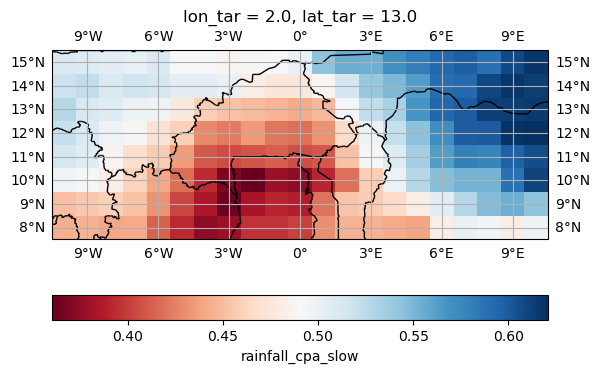

In [21]:
ax = plt.axes(projection=ccrs.PlateCarree())
plot = cpa_slow.transpose('lat_tar','lon_tar',
                          'lat_pre','lon_pre').sel(lat_tar=13, 
                                                   lon_tar=2).plot(ax=ax, 
                                                                   cmap='RdBu',
                                                                   cbar_kwargs={'orientation':'horizontal'})

# Add coastlines, gridlines, etc. if desired
ax.coastlines()
ax.add_feature(cfeature.BORDERS.with_scale('10m'))
ax.gridlines(draw_labels=True);

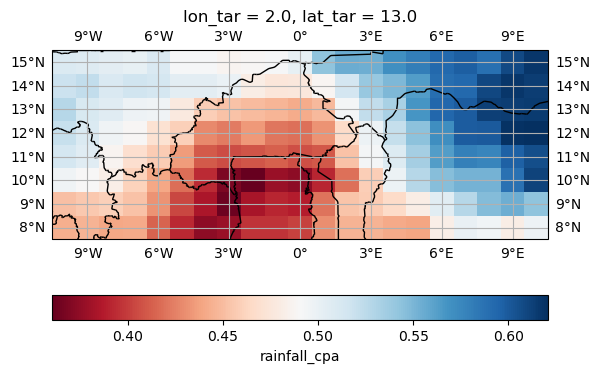

In [20]:
ax = plt.axes(projection=ccrs.PlateCarree())
plot = cpa.transpose('lat_tar','lon_tar',
                          'lat_pre','lon_pre').sel(lat_tar=13, 
                                                   lon_tar=2).plot(ax=ax, 
                                                                   cmap='RdBu',
                                                                   cbar_kwargs={'orientation':'horizontal'})

# Add coastlines, gridlines, etc. if desired
ax.coastlines()
ax.add_feature(cfeature.BORDERS.with_scale('10m'))
ax.gridlines(draw_labels=True);